In [52]:
import pennylane as qml
from qiskit import *
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

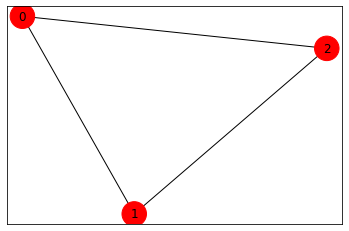

In [53]:
n_wires = 3
vertices = np.arange(0,n_wires,1)
graph = [(0, 1), (1, 2), (2, 0)]
G = nx.Graph()
G.add_edges_from(graph)
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [54]:
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2.0*beta,wires=wire)
        
def U_C(gamma):
    for edge in graph:
        wire0 = edge[0]
        wire1 = edge[1]
        qml.CNOT(wires=[wire0,wire1])
        qml.RZ(gamma,wires=wire1)
        qml.CNOT(wires=[wire0,wire1])

In [45]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [55]:
dev = qml.device("default.qubit", wires = n_wires, analytic = True, shots = 1)

In [56]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

@qml.qnode(dev)
def circuit(gammas, betas, edge = None, n_layers = 1):
    for wire in range(n_wires):
        qml.Hadamard(wires = wire)
        
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
        
    if edge is None:
        return qml.sample(comp_basis_measurement(range(n_wires)))
    
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [88]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, 2)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj


    opt = qml.AdagradOptimizer(stepsize=0.5)


    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:03b}".format(most_freq_bit_string))

    return params

angles = qaoa_maxcut(n_layers=1)


p=1
Objective after step     5:  1.8545012
Objective after step    10:  1.9698119
Objective after step    15:  1.9971177
Objective after step    20:  1.9996975
Objective after step    25:  1.9999695
Objective after step    30:  1.9999969
Optimized (gamma, beta) vectors:
[[-0.61519971]
 [-1.26371936]]
Most frequently sampled bit string is: 001


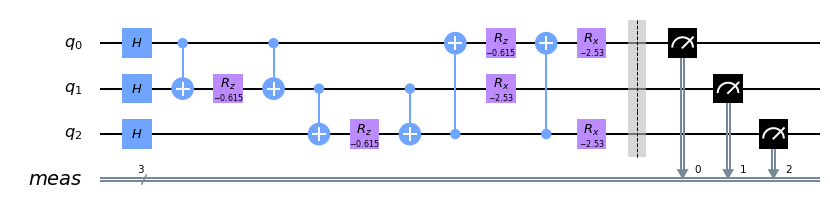

In [92]:
qc = QuantumCircuit(n_wires)
qc.h(range(n_wires))

gamma = angles[0][0]
beta = angles[1][0]


for edge in graph:
        wire0 = edge[0]
        wire1 = edge[1]
        qc.cx(wire0,wire1)
        qc.rz(gamma,wire1)
        qc.cx(wire0,wire1)

for wire in range(n_wires):
    qc.rx(2.0*beta,wire)

qc.measure_all()
qc.draw('mpl')

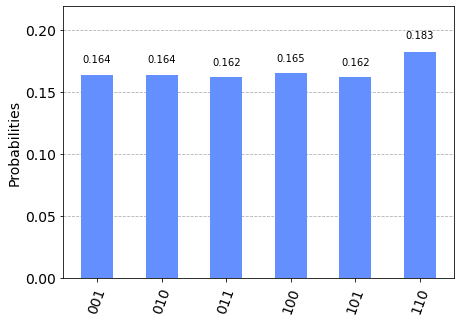

In [93]:
backend = Aer.get_backend('qasm_simulator')
result = execute(qc,backend).result().get_counts()
plot_histogram(result)